In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
# Plot parameters
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
inspector = inspect(engine)

In [11]:
# Determine the columns in the Measurement table
columns_measurement = inspector.get_columns("measurement")

for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Preview the Measurement table
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Determine the columns in the Station table
columns_stn = inspector.get_columns("station")

for column in columns_stn:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Preview the Station table
engine.execute("SELECT * FROM station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis for the last 12 months

In [16]:
# Return the latest date in the dataframe
Latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Latest_date

('2017-08-23')

In [17]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(year_ago)

2016-08-23


In [18]:
# Select the columns for the analyses
sel = [Measurement.date, Measurement.station, Measurement.prcp]

# Perform a query to retrieve the total observations and precipitation measurements
data = session.query(*sel).filter(Measurement.date > '2016-08-23').all()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data)
df = df.sort_values("date", ascending = True) # Sort the dataframe by date
df = df.set_index("date")
df.head()

,station,prcp
date,,
2016-08-24,USC00519397,0.08
2016-08-24,USC00517948,NaN
2016-08-24,USC00519281,2.15
2016-08-24,USC00514830,2.28
2016-08-24,USC00513117,2.15


In [31]:
# Use Pandas to calculate the summary statistics for precipitation
grouped = df.groupby("date").describe()
grouped.head()

prcp                                                       
           count      mean       std   min     25%    50%     75%   max
date                                                                   
2016-08-24   6.0  1.555000  0.840541  0.08  1.2775  1.800  2.1500  2.28
2016-08-25   7.0  0.077143  0.071813  0.00  0.0300  0.080  0.0950  0.21
2016-08-26   6.0  0.016667  0.016330  0.00  0.0025  0.015  0.0275  0.04
2016-08-27   5.0  0.064000  0.081731  0.00  0.0000  0.020  0.1200  0.18
2016-08-28   6.0  0.516667  0.787672  0.01  0.1400  0.140  0.4850  2.07

In [21]:
# Use the mean and the standard deviations for precipitation
pptn_df = grouped["prcp"].iloc[:, 1:3]
pptn_df.head()

,mean,std
date,,
2016-08-24,1.555000,0.840541
2016-08-25,0.077143,0.071813
2016-08-26,0.016667,0.016330
2016-08-27,0.064000,0.081731
2016-08-28,0.516667,0.787672


In [22]:
# Data type of the date
pptn_df.index.values.dtype

dtype('O')

## Precipitation Plots

In [23]:
# Date is currently set as string; need to convert to datetime and then to period format
# Resource: http://earthpy.org/time_series_analysis_with_pandas_part_2.html

pptn_df["mean"].index = pd.to_datetime(pptn_df["mean"].index) # string to datetime
pptn_df.index = pptn_df["mean"].to_period(freq = "D").index # time stamps to daily time periods
pptn_df.index

PeriodIndex(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
             '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31',
             '2016-09-01', '2016-09-02',
             ...
             '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
             '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
             '2017-08-22', '2017-08-23'],
            dtype='period[D]', name='date', length=365, freq='D')

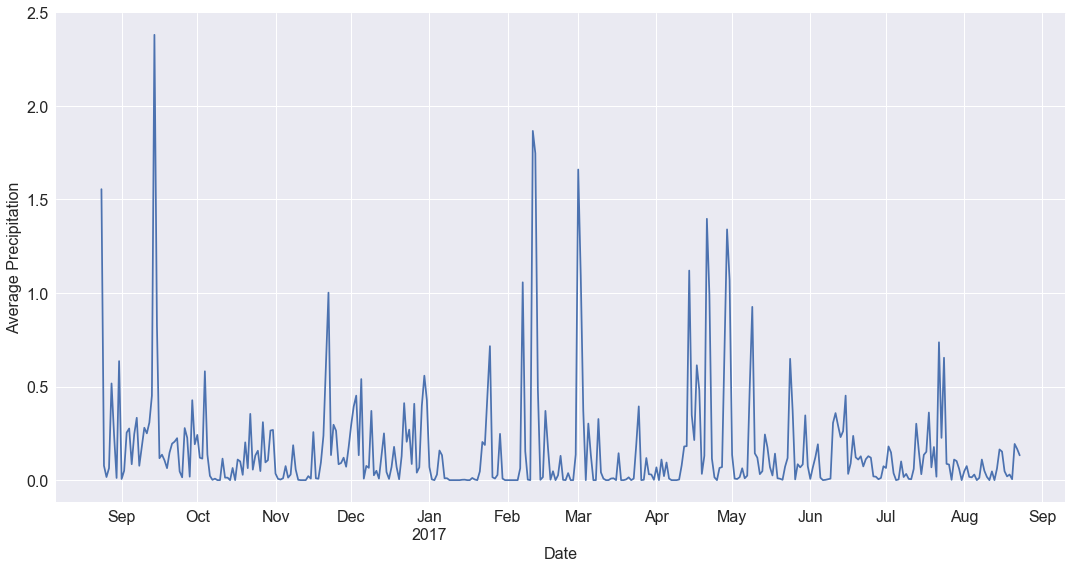

In [24]:
# Timeseries plot by a daily frequency
pptn_df.plot(y = "mean", figsize = (15,8), legend = False)
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Average Precipitation", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/pptn.svg")

In [25]:
# Get the mean by month
pptn_df_monthly_avg = pptn_df.iloc[:, 0:1].resample("M").mean() 
pptn_df_monthly_avg

,mean
date,
2016-08,0.390060
2016-09,0.280033
2016-10,0.120344
2016-11,0.130408
2016-12,0.199009
2017-01,0.075740
2017-02,0.225781
2017-03,0.157887
2017-04,0.315187


y = -0.013x + 0.259


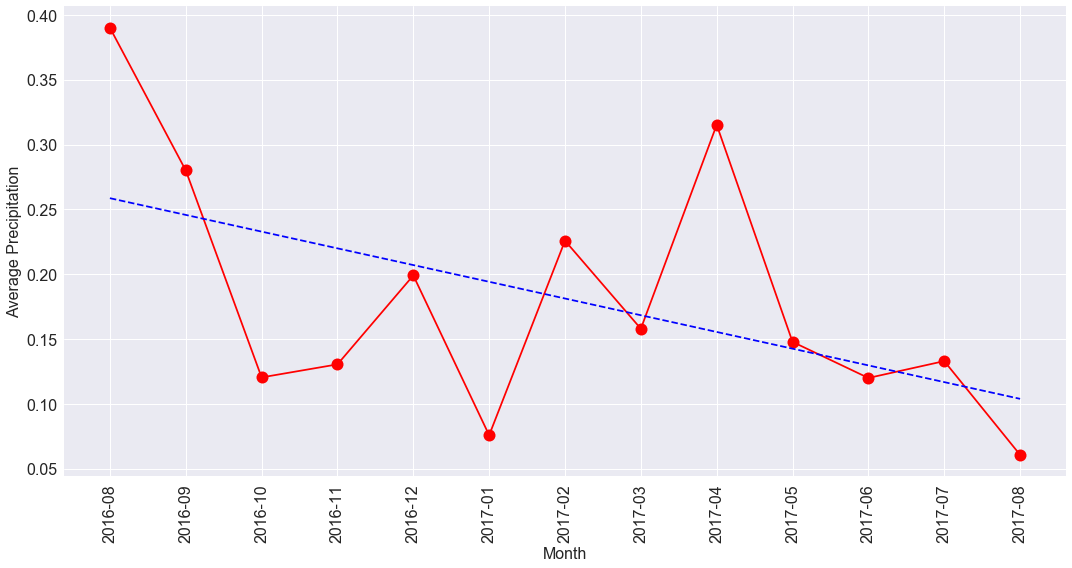

In [26]:
# Monthly precipitation averages for one year
x = np.arange(len(pptn_df_monthly_avg.index))
y = pptn_df_monthly_avg["mean"].values
plt.figure(figsize = (15,8))
plt.plot(x, y, marker = "o", markersize = 12, color = "red")

# Calculate the trendline (linear fitting)
# Resource: http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x),"b--")

# the line equation:
print(f"y = %.3fx + %.3f"%(z[0],z[1]))

# Plot attributes
plt.ylabel("Average Precipitation", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(x, pptn_df_monthly_avg.index.values, rotation = 90)
plt.tight_layout()

## Station Analysis

In [55]:
# Merge the measurement and the station tables based on station id
sel2 = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs,
       Station.name, Station.elevation, Station.latitude, Station.longitude]

same_stn = session.query(*sel2).filter(Measurement.station == Station.station).\
           limit(5).all()

for record in same_stn:
    print(
        f"{record[0]} is found at {record[5]} above sea level.\n{record[0]} is also called {record[4]}.")

USC00519397 is found at 3.0 above sea level.
USC00519397 is also called WAIKIKI 717.2, HI US.
USC00519397 is found at 3.0 above sea level.
USC00519397 is also called WAIKIKI 717.2, HI US.
USC00519397 is found at 3.0 above sea level.
USC00519397 is also called WAIKIKI 717.2, HI US.
USC00519397 is found at 3.0 above sea level.
USC00519397 is also called WAIKIKI 717.2, HI US.
USC00519397 is found at 3.0 above sea level.
USC00519397 is also called WAIKIKI 717.2, HI US.


In [47]:
# Select the columns for the analyses
sel3 = [Measurement.station, func.count(Measurement.station)]

# Design a query to show how many stations are available in this dataset (descending stn count)
stn_count = session.query(*sel3).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).\
            all()

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Select the most active station (most number of measurements)
most_active_stn = stn_count[0][0]

In [77]:
# Using the station id from the previous query, calculate the lowest temperature recorded
# in the most active station.
min_temp = session.query(func.min(Measurement.tobs)).\
           filter(Measurement.station == most_active_stn).all()

print(f"The minimum temperature at {most_active_stn} is {min_temp[0][0]} °F.")

The minimum temperature at USC00519281 is 54.0 °F.


In [78]:
# Using the station id from the previous query, calculate the highest temperature recorded
# in the most active station.
max_temp = session.query(func.max(Measurement.tobs)).\
           filter(Measurement.station == most_active_stn).all()

print(f"The maximum temperature at {most_active_stn} is {max_temp[0][0]} °F.")

The maximum temperature at USC00519281 is 85.0 °F.


In [82]:
# Using the station id from the previous query, calculate the average temperature 
# in the most active station.

avg_temp = session.query(func.avg(Measurement.tobs)).\
           filter(Measurement.station == most_active_stn).all()

print(f"The average temperature at {most_active_stn} is {round((avg_temp[0][0]),1)} °F.")

The average temperature at USC00519281 is 71.7 °F.


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
